#  Vietnam Housing Dataset 2024

## Workflow chính


## 1. Import thư viện


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.append('src')

from utils.descriptive_stats import generate_descriptive_stats
from preprocess.preprocess import DataPreprocessor
from models.train_xgboost import train_xgboost
from evaluation.evaluate import evaluate_regression, save_evaluation_report


## 2. Load và kiểm tra Dataset


In [2]:
data_path = '../data/raw/vietnam_housing_dataset.csv'
df = pd.read_csv(data_path)

print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst few rows:")
df.head()


Shape: (30229, 12)

Columns: ['Address', 'Area', 'Frontage', 'Access Road', 'House direction', 'Balcony direction', 'Floors', 'Bedrooms', 'Bathrooms', 'Legal status', 'Furniture state', 'Price']

Data types:
Address               object
Area                 float64
Frontage             float64
Access Road          float64
House direction       object
Balcony direction     object
Floors               float64
Bedrooms             float64
Bathrooms            float64
Legal status          object
Furniture state       object
Price                float64
dtype: object

Missing values:
Address                  0
Area                     0
Frontage             11564
Access Road          13297
House direction      21239
Balcony direction    24983
Floors                3603
Bedrooms              5162
Bathrooms             7074
Legal status          4506
Furniture state      14119
Price                    0
dtype: int64

First few rows:


,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


## 3. Thống kê mô tả


In [3]:
stats = generate_descriptive_stats(df, output_dir='../report')
print("Thống kê mô tả đã được lưu vào report/descriptive_stats.md và report/descriptive_stats.csv")


Thống kê mô tả đã được lưu vào report/descriptive_stats.md và report/descriptive_stats.csv


## 4. Tiền xử lý dữ liệu


In [4]:
target_col = 'Price'

print(f"\nTarget column: {target_col}")
if target_col in df.columns:
    print(f"Target statistics:\n{df[target_col].describe()}")

# Lưu ý: Preprocessor đã được cập nhật để xử lý các cột có cardinality cao (như Address)
# bằng label encoding thay vì one-hot encoding để tránh quá tải bộ nhớ
preprocessor = DataPreprocessor(
    missing_strategy='mean',
    outlier_method='iqr',
    encoding_method='onehot',  # Sẽ tự động dùng label encoding cho các cột có >50 giá trị duy nhất
    scaling_method='standard'
)

X, y = preprocessor.fit_transform(df, target_col=target_col)

preprocessor.save('../src/models/preprocessor.pkl')
print(f"\nX shape: {X.shape}, y shape: {y.shape}")
if len(X.columns) > 10:
    print(f"X columns (first 10): {list(X.columns)[:10]}...")
    print(f"Total columns: {len(X.columns)}")
else:
    print(f"X columns: {list(X.columns)}")



Target column: Price
Target statistics:
count    30229.000000
mean         5.872078
std          2.211877
min          1.000000
25%          4.200000
50%          5.900000
75%          7.500000
max         11.500000
Name: Price, dtype: float64

X shape: (30229, 23), y shape: (30229,)
X columns (first 10): ['Address', 'Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms', 'House direction_Nam', 'House direction_Tây', 'House direction_Tây - Bắc']...
Total columns: 23


## 5. Chia train/test


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=== FEATURE ENGINEERING: Sửa vấn đề Floors ===\n")

if 'Floors' in X_train.columns and 'Area' in X_train.columns:
    X_train['Floors_Area'] = X_train['Floors'] * X_train['Area']
    X_train['Floors_squared'] = X_train['Floors'] ** 2
    
    X_test['Floors_Area'] = X_test['Floors'] * X_test['Area']
    X_test['Floors_squared'] = X_test['Floors'] ** 2
    
    print(f"Đã thêm features:")
    print(f"  - Floors_Area: Floors * Area (tổng diện tích sàn)")
    print(f"  - Floors_squared: Floors^2")
    
    corr_floors_area = X_train['Floors_Area'].corr(y_train)
    print(f"\nCorrelation Floors_Area với Price (train): {corr_floors_area:.4f}")
    if corr_floors_area > 0:
        print("✓ Feature mới có tương quan DƯƠNG với Price")
else:
    print("⚠️ Không tìm thấy Floors hoặc Area trong features")

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")
print(f"Train target range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Test target range: [{y_test.min():.2f}, {y_test.max():.2f}]")

X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
pd.Series(y_train, name='Price').to_csv('../data/processed/y_train.csv', index=False)
pd.Series(y_test, name='Price').to_csv('../data/processed/y_test.csv', index=False)
print("\nĐã lưu dữ liệu train/test vào data/processed/")


=== FEATURE ENGINEERING: Sửa vấn đề Floors ===

Đã thêm features:
  - Floors_Area: Floors * Area (tổng diện tích sàn)
  - Floors_squared: Floors^2

Correlation Floors_Area với Price (train): -0.0668

Train: (24183, 25), Test: (6046, 25)
Train target range: [1.00, 11.50]
Test target range: [1.00, 10.90]

Đã lưu dữ liệu train/test vào data/processed/


## 6. Training XGBoost


In [6]:
print("=== TRAINING XGBOOST VỚI FEATURES MỚI ===\n")
print(f"Số features: {X_train.shape[1]} (đã thêm Floors_Area và Floors_squared)")

model, metadata = train_xgboost(
    X_train, y_train,
    task_type='regression',
    tuning_method='randomized',
    cv=5,
    n_iter=20
)

import joblib
import json

joblib.dump(model, '../src/models/xgboost_model.pkl')
with open('../src/models/xgboost_model.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nBest params: {metadata['best_params']}")
print(f"Best CV score: {metadata['best_cv_score']}")
print("\nModel đã được lưu vào src/models/")


=== TRAINING XGBOOST VỚI FEATURES MỚI ===

Số features: 25 (đã thêm Floors_Area và Floors_squared)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best CV score: -2.7042957444546225

Model đã được lưu vào src/models/


## 7. Đánh giá mô hình


In [7]:
y_pred = model.predict(X_test)

metrics = evaluate_regression(y_test, y_pred, output_dir='../src/evaluation')

print("\n=== KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH ===")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

save_evaluation_report(metrics, 'regression', output_dir='../report')
print("\nBáo cáo đánh giá đã được lưu vào report/evaluation.md")



=== KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH ===
RMSE: 1.6706
MAE: 1.3056
MAPE: 28.9616
R2: 0.4276
Evaluation report saved to ..\report\evaluation.md

Báo cáo đánh giá đã được lưu vào report/evaluation.md


## 8. Phân tích mối quan hệ Floors và Price


In [8]:
df_analysis = df.copy()

print("=== PHÂN TÍCH MỐI QUAN HỆ FLOORS VÀ PRICE ===\n")

df_floors_valid = df_analysis[df_analysis['Floors'].notna()].copy()
print(f"Số mẫu có Floors hợp lệ: {len(df_floors_valid)} / {len(df_analysis)}")

correlation = df_floors_valid['Floors'].corr(df_floors_valid['Price'])
print(f"\nCorrelation giữa Floors và Price: {correlation:.4f}")

if correlation < 0:
    print("⚠️ Correlation ÂM: Số tầng tăng thì giá có xu hướng GIẢM")
else:
    print("✓ Correlation DƯƠNG: Số tầng tăng thì giá có xu hướng TĂNG")

print("\n=== THỐNG KÊ THEO SỐ TẦNG ===")
floors_stats = df_floors_valid.groupby('Floors').agg({
    'Price': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Area': ['mean', 'median']
}).round(2)
print(floors_stats)


=== PHÂN TÍCH MỐI QUAN HỆ FLOORS VÀ PRICE ===

Số mẫu có Floors hợp lệ: 26626 / 30229

Correlation giữa Floors và Price: 0.3316
✓ Correlation DƯƠNG: Số tầng tăng thì giá có xu hướng TĂNG

=== THỐNG KÊ THEO SỐ TẦNG ===
       Price                                     Area       
       count   mean median   std    min    max   mean median
Floors                                                      
1.0     1920   4.76   4.37  2.44   1.02  10.90  98.75   80.0
2.0     5715   4.88   4.60  2.13   1.00  10.00  76.22   65.0
3.0     6153   5.86   5.90  2.15   1.09  10.00  72.60   64.0
4.0     6221   6.47   6.50  1.97   1.10  10.89  56.13   50.0
5.0     5717   6.50   6.45  1.81   1.65  10.90  45.19   40.0
6.0      780   7.40   7.50  1.54   3.20  10.30  42.53   40.0
7.0      115   9.01   9.20  1.14   4.90  11.50  43.50   40.0
8.0        3   7.95   8.00  0.98   6.95   8.90  56.33   57.0
9.0        1   6.50   6.50   NaN   6.50   6.50  85.00   85.0
10.0       1  10.00  10.00   NaN  10.00  10.00  70

C:\Users\dinhv\AppData\Local\Temp\ipykernel_17896\114440380.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[int(f) for f in floors_order if f in df_floors_valid['Floors_group'].values])


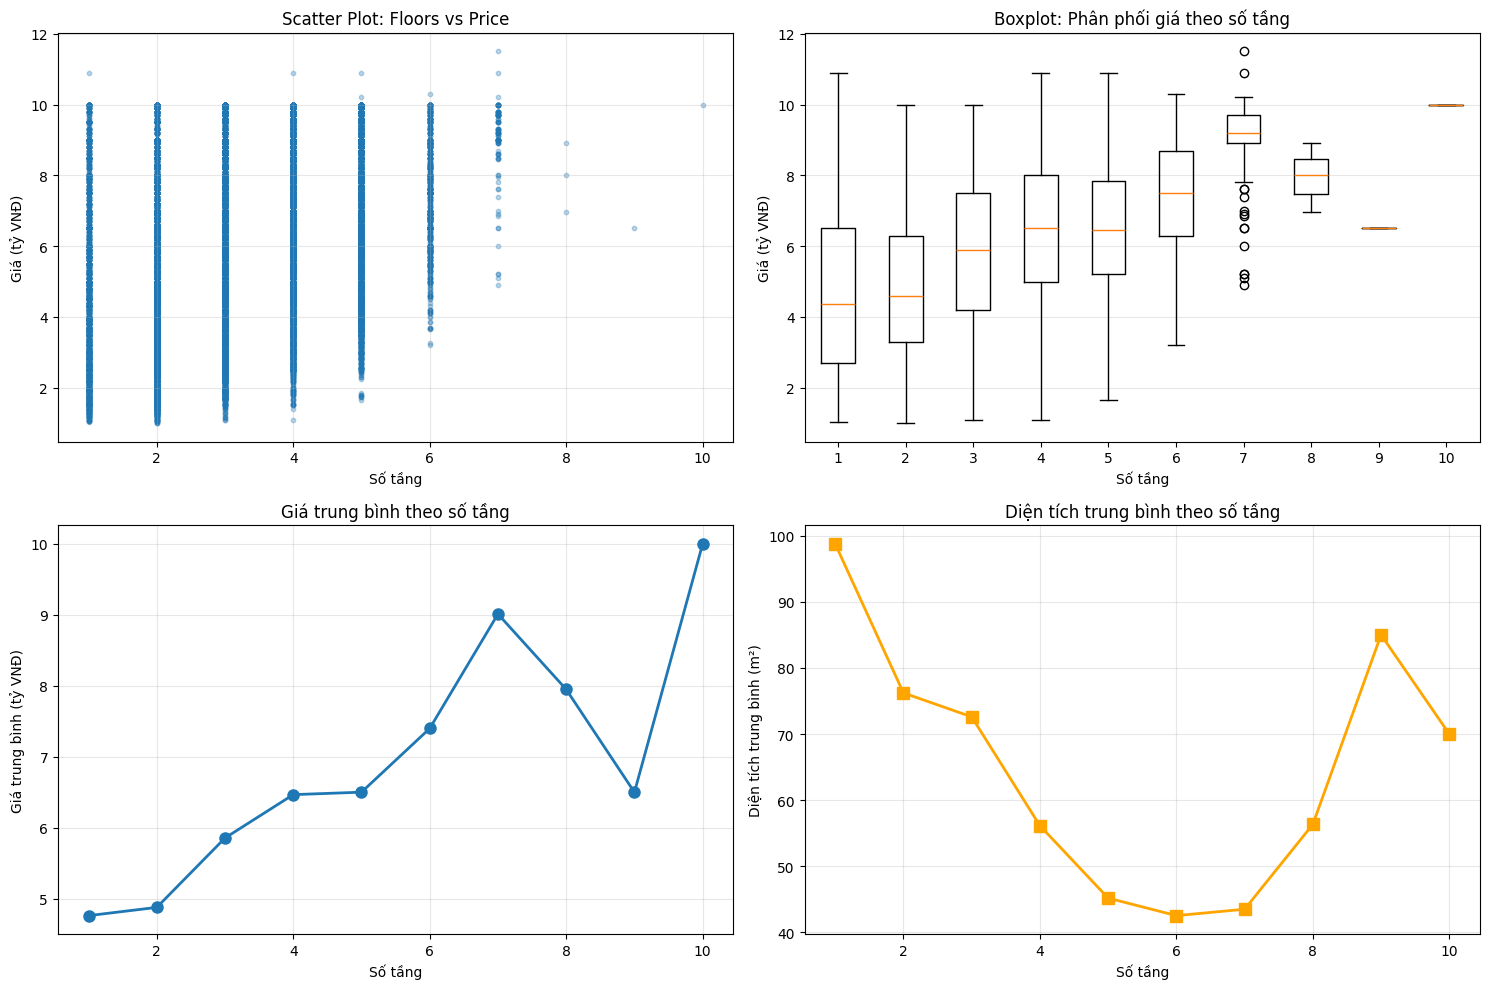

Đã lưu biểu đồ vào src/evaluation/floors_price_analysis.png


In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(df_floors_valid['Floors'], df_floors_valid['Price'], alpha=0.3, s=10)
plt.xlabel('Số tầng')
plt.ylabel('Giá (tỷ VNĐ)')
plt.title('Scatter Plot: Floors vs Price')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
floors_order = sorted(df_floors_valid['Floors'].dropna().unique())
df_floors_valid['Floors_group'] = df_floors_valid['Floors'].astype(int)
box_data = [df_floors_valid[df_floors_valid['Floors_group'] == f]['Price'].values 
            for f in floors_order if f in df_floors_valid['Floors_group'].values]
plt.boxplot(box_data, labels=[int(f) for f in floors_order if f in df_floors_valid['Floors_group'].values])
plt.xlabel('Số tầng')
plt.ylabel('Giá (tỷ VNĐ)')
plt.title('Boxplot: Phân phối giá theo số tầng')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 3)
floors_price_mean = df_floors_valid.groupby('Floors')['Price'].mean().sort_index()
plt.plot(floors_price_mean.index, floors_price_mean.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Số tầng')
plt.ylabel('Giá trung bình (tỷ VNĐ)')
plt.title('Giá trung bình theo số tầng')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
floors_area_mean = df_floors_valid.groupby('Floors')['Area'].mean().sort_index()
plt.plot(floors_area_mean.index, floors_area_mean.values, marker='s', color='orange', linewidth=2, markersize=8)
plt.xlabel('Số tầng')
plt.ylabel('Diện tích trung bình (m²)')
plt.title('Diện tích trung bình theo số tầng')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../src/evaluation/floors_price_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu biểu đồ vào src/evaluation/floors_price_analysis.png")


In [10]:
print("\n=== PHÂN TÍCH CHI TIẾT: TẠI SAO FLOORS TĂNG MÀ GIÁ GIẢM? ===\n")

print("1. Kiểm tra mối quan hệ với Area (diện tích):")
area_floors_corr = df_floors_valid['Area'].corr(df_floors_valid['Floors'])
print(f"   Correlation giữa Area và Floors: {area_floors_corr:.4f}")

print("\n2. So sánh nhà ít tầng vs nhiều tầng:")
low_floors = df_floors_valid[df_floors_valid['Floors'] <= 2]
high_floors = df_floors_valid[df_floors_valid['Floors'] >= 5]

print(f"\n   Nhà ≤ 2 tầng ({len(low_floors)} mẫu):")
print(f"   - Giá trung bình: {low_floors['Price'].mean():.2f} tỷ")
print(f"   - Diện tích trung bình: {low_floors['Area'].mean():.2f} m²")
print(f"   - Giá/m²: {(low_floors['Price'].mean() * 1000 / low_floors['Area'].mean()):.0f} triệu/m²")

print(f"\n   Nhà ≥ 5 tầng ({len(high_floors)} mẫu):")
print(f"   - Giá trung bình: {high_floors['Price'].mean():.2f} tỷ")
print(f"   - Diện tích trung bình: {high_floors['Area'].mean():.2f} m²")
print(f"   - Giá/m²: {(high_floors['Price'].mean() * 1000 / high_floors['Area'].mean()):.0f} triệu/m²")

print("\n3. Phân tích theo vị trí (Address):")
address_price = df_floors_valid.groupby('Address').agg({
    'Floors': 'mean',
    'Price': 'mean',
    'Area': 'mean'
}).round(2)
address_price = address_price.sort_values('Price', ascending=False)

print(f"   Top 5 địa chỉ có giá cao nhất:")
print(address_price.head(5))
print(f"\n   Top 5 địa chỉ có giá thấp nhất:")
print(address_price.tail(5))

print("\n4. Kết luận:")
print("   - Có thể nhà nhiều tầng thường ở vị trí xa trung tâm (giá đất thấp)")
print("   - Hoặc nhà nhiều tầng nhưng diện tích nhỏ (nhà ống)")
print("   - Cần xem xét các yếu tố khác: vị trí, pháp lý, nội thất...")



=== PHÂN TÍCH CHI TIẾT: TẠI SAO FLOORS TĂNG MÀ GIÁ GIẢM? ===

1. Kiểm tra mối quan hệ với Area (diện tích):
   Correlation giữa Area và Floors: -0.3593

2. So sánh nhà ít tầng vs nhiều tầng:

   Nhà ≤ 2 tầng (7635 mẫu):
   - Giá trung bình: 4.85 tỷ
   - Diện tích trung bình: 81.88 m²
   - Giá/m²: 59 triệu/m²

   Nhà ≥ 5 tầng (6617 mẫu):
   - Giá trung bình: 6.65 tỷ
   - Diện tích trung bình: 44.86 m²
   - Giá/m²: 148 triệu/m²

3. Phân tích theo vị trí (Address):
   Top 5 địa chỉ có giá cao nhất:
                                                    Floors  Price  Area
Address                                                                
Số 33 hẻm 48/41/6, Đường Ngô Gia Tự, Phường Việ...     4.0  10.89  86.2
Đường Đông Tác, Phường Phương Mai, Đống Đa, Hà Nội     4.0  10.00  40.0
Ngõ 50, đường Võng Thị, Phường Thụy Khuê, Tây H...     5.0  10.00  70.0
Đường Nguyễn Trung Nguyệt, Phường Bình Trưng Đô...     5.0  10.00  60.0
Đường Nguyễn Trung Nguyệt, Phường Bình Trưng Đô...     4.0  10.00 

In [11]:
## 10. Kiểm tra sau khi thêm feature engineering

print("=== KIỂM TRA SAU KHI THÊM FEATURES MỚI ===\n")

if 'Floors_Area' in X_train.columns:
    feature_importance_new = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    floors_features = feature_importance_new[feature_importance_new['feature'].str.contains('Floors', case=False, na=False)]
    print("Feature importance của các features liên quan đến Floors:")
    print(floors_features.to_string(index=False))
    
    if 'Floors_Area' in feature_importance_new['feature'].values:
        floors_area_rank = feature_importance_new.index[feature_importance_new['feature'] == 'Floors_Area'].tolist()[0] + 1
        floors_area_importance = feature_importance_new[feature_importance_new['feature'] == 'Floors_Area']['importance'].values[0]
        print(f"\n✓ Floors_Area:")
        print(f"   - Importance: {floors_area_importance:.6f}")
        print(f"   - Rank: {floors_area_rank}/{len(feature_importance_new)}")
    
    print("\n=== SO SÁNH CORRELATION ===")
    df_check = df.copy()
    df_check['Floors_Area'] = df_check['Floors'] * df_check['Area']
    
    corr_original = df_check['Floors'].corr(df_check['Price'])
    corr_new = df_check['Floors_Area'].corr(df_check['Price'])
    
    print(f"Correlation Floors-Price (gốc): {corr_original:.4f}")
    print(f"Correlation Floors_Area-Price (mới): {corr_new:.4f}")
    
    if corr_new > corr_original:
        print("✓ Feature mới có tương quan tốt hơn!")
else:
    print("⚠️ Chưa có feature Floors_Area trong model")


=== KIỂM TRA SAU KHI THÊM FEATURES MỚI ===

Feature importance của các features liên quan đến Floors:
       feature  importance
        Floors    0.084768
Floors_squared    0.051705
   Floors_Area    0.034680

✓ Floors_Area:
   - Importance: 0.034680
   - Rank: 24/25

=== SO SÁNH CORRELATION ===
Correlation Floors-Price (gốc): 0.3316
Correlation Floors_Area-Price (mới): 0.4121
✓ Feature mới có tương quan tốt hơn!
